In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(123)
import pandas as pd
import nibabel as nib
import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from matplotlib import pyplot as plt
from matplotlib import cm
from keras import backend as K
from keras_fcn import FCN
from keras_contrib.applications.densenet import DenseNet, DenseNetFCN
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [3]:
def get_file_data(file):
    file_img = nib.load(file)
    file_affine = file_img.get_affine()
    file_data = file_img.get_data()
    return file_data, file_affine

def save_image(file_data, file_affine, file_name):
    image = nib.Nifti1Image(file_data, file_affine)
    image.to_filename(file_name)
    return

# Load images (X)
# Reshape, convert to float, normalize between 0 and 1
def load_images(image_folder):
    images = sorted(glob.glob(image_folder+'/*'))
    num_images = len(images)
    test_data, test_aff = get_file_data(images[0])
    img_x, img_y = test_data.shape
    X = np.zeros((num_images, img_x, img_y, 1))
    for i, image in enumerate(images):
        data, aff = get_file_data(image)
        X[i,:,:,0] = data
    X = X.astype('float32')
    max_X = np.amax(X)
    X /= max_X 
    return X

# Load clinical metrics (Y)
# Convert to categorical variable array
def load_clinical_metrics(csv_file, metric_name):
    df = pd.read_csv(csv_file)
    metric = df[metric_name]
    Y = metric.values
    num_categories = len(np.unique(Y))
    Y = np_utils.to_categorical(Y, num_categories)
    return Y

In [4]:
X = load_images('/data/henry6/esha/CNN/low_res_img_data_32')
X.shape

Y = load_images('/data/henry6/esha/CNN/low_res_gm_mask_data_32')
Y = Y.astype('int')

# Split into test and training groups
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.1)
#X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train,test_size=.1)
print(X_train.shape)
#print(X_valid.shape)
print(X_test.shape)

(134, 32, 32, 1)
(15, 32, 32, 1)


In [5]:
#DenseNet implementation
img_dim = (32,32,1)
model = DenseNetFCN(img_dim, nb_dense_block=1, growth_rate=2, nb_layers_per_block=2)

In [5]:
#Alternate FCN implementation
model = FCN(input_shape=(32, 32, 1), classes=1)

In [7]:
model.summary()
optimizer = 'rmsprop'
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 32, 32, 48)    432         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32, 32, 48)    192         initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 48)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
model.fit(X_train, Y_train, batch_size=32, nb_epoch=10, verbose=0)

/home/edatta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


In [12]:
Y_predict = model.predict_on_batch(X_test)
Y_predict_prob = model.predict(X_test)

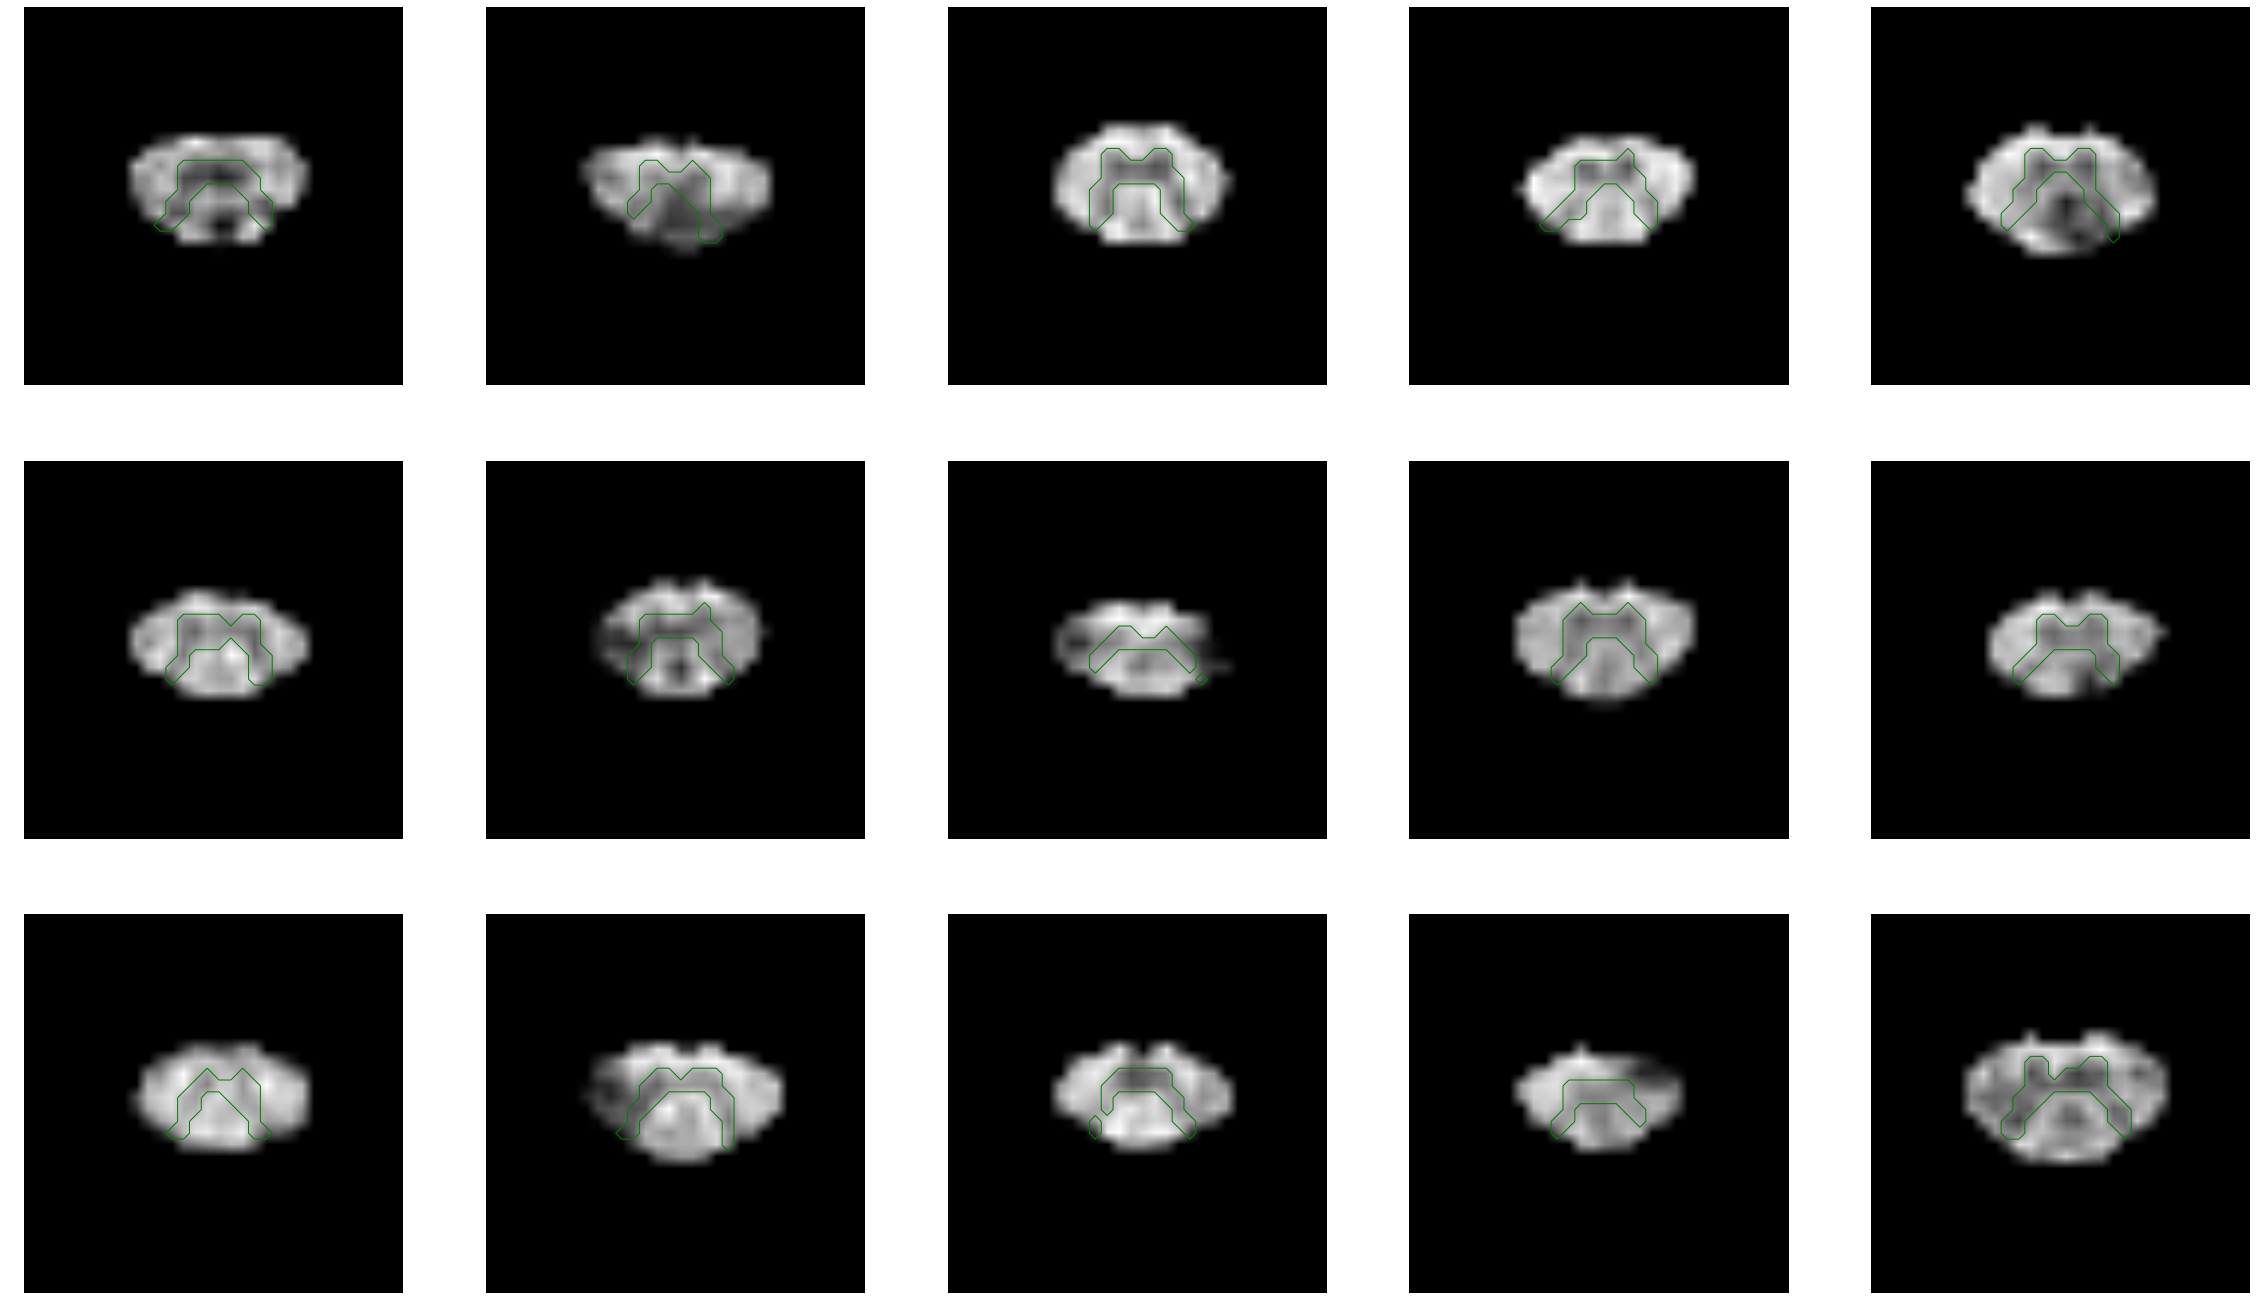

In [13]:
plt.figure(figsize=(40,80)) 
fig = plt.gcf()
for img_num in xrange(len(X_test)):
    img = X_test[img_num,:,:,0]
    mask = Y_test[img_num,:,:,0]
    predicted_mask = Y_predict[img_num,:,:,0]
    ax = fig.add_subplot(10,5,img_num+1)
    ax.axis('off')
    cordmin = np.amin(img[img!=0])
    cordmax = np.amax(img[img!=0])
    ax.imshow(np.flipud(np.transpose(img)), cmap=cm.gray, vmin=cordmin, vmax=cordmax)
    ax.contour(np.flipud(np.transpose(mask)), [0.5], colors='g')
    #ax.imshow(np.flipud(np.transpose(predicted_mask)))
    ax.contour(np.flipud(np.transpose(predicted_mask)), [0.5], colors='r')

In [15]:
# See how well Model scores
score = model.evaluate(X_test, Y_test, verbose=0)